### 🧩 Problem Statement

In today’s globalized economy, countries vary significantly in terms of economic performance and policy direction. However, these differences are often complex and not easily grouped by geography or development status alone. This project aims to uncover hidden economic patterns across countries by applying unsupervised machine learning, specifically clustering algorithms, to a set of key economic indicators.

By analyzing metrics such as GDP growth, unemployment, inflation, interest rates, and stock index values, we seek to group countries with similar economic characteristics. These clusters will provide insight into how countries align economically, potentially identifying groups that face similar economic challenges or follow similar development paths.

This analysis will support:

    * Geopolitical and economic understanding of global trends.

    * Data-driven policy comparison between similar economies.

    * And a basis for further economic forecasting or strategy design.

### Data Cleaning

In [58]:
# Checking the last few rows of a DataFrame
import pandas as pd 
import numpy as np

df = pd.read_csv('../Clustering Countries Based on Economic Indicators Project/Data.csv')
df.tail()

,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
495,2023-08-31,Japan,5.71,-3.85,4.69,8.50,5968.07
496,2023-08-31,UK,4.82,8.95,10.91,8.87,21731.52
497,2023-09-30,USA,7.32,0.61,9.36,4.58,38924.38
498,2023-10-31,Germany,8.04,-2.23,2.89,8.04,39107.07
499,2023-11-30,Australia,9.23,6.16,6.78,9.49,21072.66


In [59]:
# Checking for missing values in the DataFrame
df.isnull().sum()

Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
dtype: int64

In [60]:
# Checking for duplicate rows in the DataFrame
df.duplicated().sum()

np.int64(0)

In [61]:
# Displaying the data types of each column in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   500 non-null    object 
 1   Country                500 non-null    object 
 2   Inflation Rate (%)     500 non-null    float64
 3   GDP Growth Rate (%)    500 non-null    float64
 4   Unemployment Rate (%)  500 non-null    float64
 5   Interest Rate (%)      500 non-null    float64
 6   Stock Index Value      500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB


In [62]:
# Displaying summary statistics of the DataFrame
df.describe()

,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
count,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.08514,2.414780,6.906720,4.698180,20926.226540
std,2.95633,4.074762,2.982406,3.152877,11066.259233
min,0.00000,-5.000000,2.000000,-0.980000,1017.270000
25%,2.52500,-1.170000,4.257500,2.027500,11587.862500
50%,5.20500,2.580000,6.865000,4.975000,20996.210000
75%,7.71000,5.445000,9.502500,7.352500,30824.847500
max,9.99000,9.930000,11.970000,10.000000,39982.210000


In [63]:
# Displaying summary statistics for object type columns in the DataFrame
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
Date,500,156,2018-03-31,9
Country,500,10,France,59


In [64]:
# Displaying the unique values in the 'Country' column
df['Country'].unique()

array(['Brazil', 'France', 'USA', 'Canada', 'Japan', 'Germany', 'China',
       'UK', 'India', 'Australia'], dtype=object)

In [65]:
df.select_dtypes(include=['float64']).columns

Index(['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Unemployment Rate (%)',
       'Interest Rate (%)', 'Stock Index Value'],
      dtype='object')

### Exploratory Data Analysis (EDA)

In [66]:
# Generating a profiling report for the DataFrame
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<?, ?it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

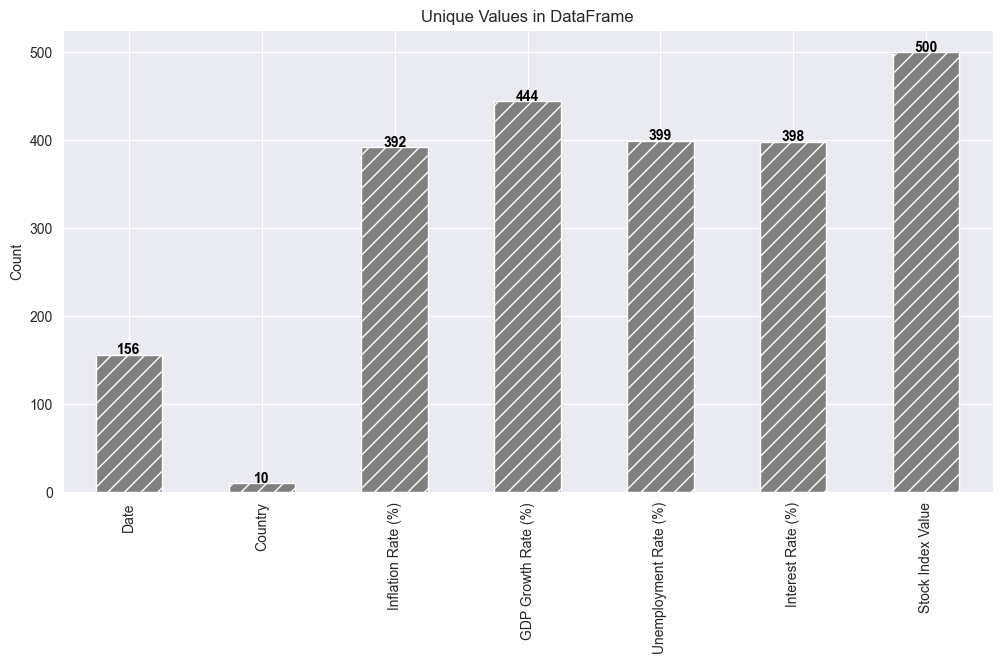

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Unique Values
unique = df.nunique()
plt.figure(figsize=(12, 6))
unique.plot(kind='bar', color ='grey', hatch='//')
plt.title('Unique Values in DataFrame')
plt.ylabel('Count')
for i,v in enumerate(unique):
    plt.text(i, v + 1, str(v), color='black', fontweight='bold', ha='center')
plt.show()


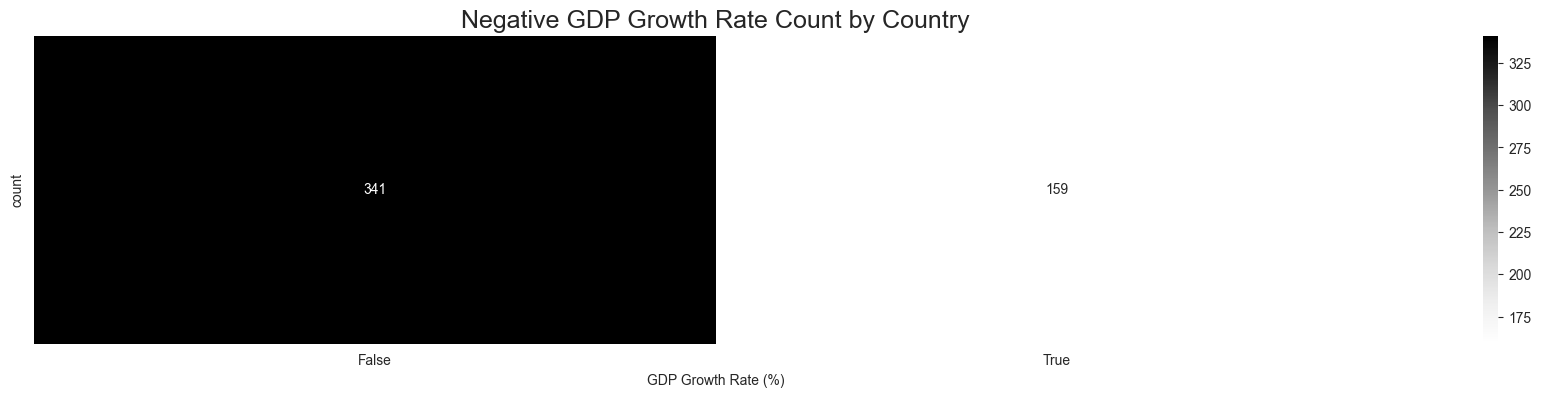

In [68]:
# Number Of Negative Values of GDP
neg_values = df['GDP Growth Rate (%)'] < 0

plt.figure(figsize=(22, 4))
sns.heatmap(pd.DataFrame(neg_values.value_counts()).T, annot=True, cmap='Greys', fmt='0.0f').set_title('Negative GDP Growth Rate Count by Country', fontsize=18)
plt.show()

In [69]:
# Getting the indices of the negative values in the 'GDP Growth Rate (%)' column
neg_indices = df.loc[neg_values].index
neg_indices

Index([  4,   8,   9,  11,  13,  16,  25,  29,  34,  35,
       ...
       465, 468, 474, 482, 489, 491, 492, 493, 495, 498],
      dtype='int64', length=159)

In [70]:
# Highlighting Negative GDP Growth Rate Values in DataFrame
def red_neg(v):
    return 'background-color: lightcoral; color: white' if v < 0 else ''

df_neg_gdp = df[df['GDP Growth Rate (%)']<0].head(25)
df_neg_gdp = df_neg_gdp.style.map(lambda v: 'background-color: lightcoral; color: white' if v<0 else '', subset=['GDP Growth Rate (%)'])
df_neg_gdp


,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
4,2010-02-28,Canada,0.690000,-0.520000,11.920000,-0.510000,16413.030000
8,2010-03-31,Germany,0.050000,-4.780000,3.310000,3.850000,38146.220000
9,2010-03-31,USA,7.200000,-1.480000,4.100000,8.220000,6067.710000
11,2010-04-30,Germany,8.840000,-2.870000,4.820000,3.990000,25382.990000
13,2010-05-31,France,5.690000,-4.860000,3.610000,8.790000,12514.430000
16,2010-06-30,France,8.380000,-4.760000,6.410000,2.340000,37646.410000
25,2010-09-30,Canada,5.270000,-3.960000,3.510000,8.370000,16636.730000
29,2010-12-31,Canada,9.890000,-1.480000,4.780000,4.780000,2858.010000
34,2011-01-31,UK,5.660000,-3.450000,3.780000,3.350000,32903.040000
35,2011-01-31,USA,0.090000,-1.820000,11.920000,-0.060000,31674.370000


In [71]:
# Defining numeric and categorical columns for further analysis
numeric_cols = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Unemployment Rate (%)',
       'Interest Rate (%)', 'Stock Index Value']
cat_columns = ['Country', 'Date']

In [72]:
# Function to plot numerical features boxplot and identify outliers
def plot_numerical_features_boxplot(data, columns_list, rows, cols, title):
    sns.set_style("darkgrid")
    fig, axs = plt.subplots(rows, cols, figsize=(15, 7), sharey=True)
    fig.suptitle(title, fontsize=16, y=1)
    axs = axs.flatten()
    outliers_df = pd.DataFrame(columns=['Column', 'Outliers_index', 'Outliers_value'])

    records = []
    for i, col in enumerate(columns_list):
        sns.boxplot(x=data[col], ax=axs[i], color='#404B69')
        axs[i].set_title(f'{col} (skewness: {data[col].skew()})', fontsize=12)

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))
        outliers_index = data[outliers].index.tolist()
        outliers_index = data[outliers][col].tolist()
        records.append({'Column': col, 'Outliers_index':  outliers_index, 'Outliers_value': outliers_index})
        axs[i].plot([], [], 'ro', alpha=0.5, label=f'Outliers: {outliers.sum()}')
        axs[i].legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    return pd.DataFrame(records)    

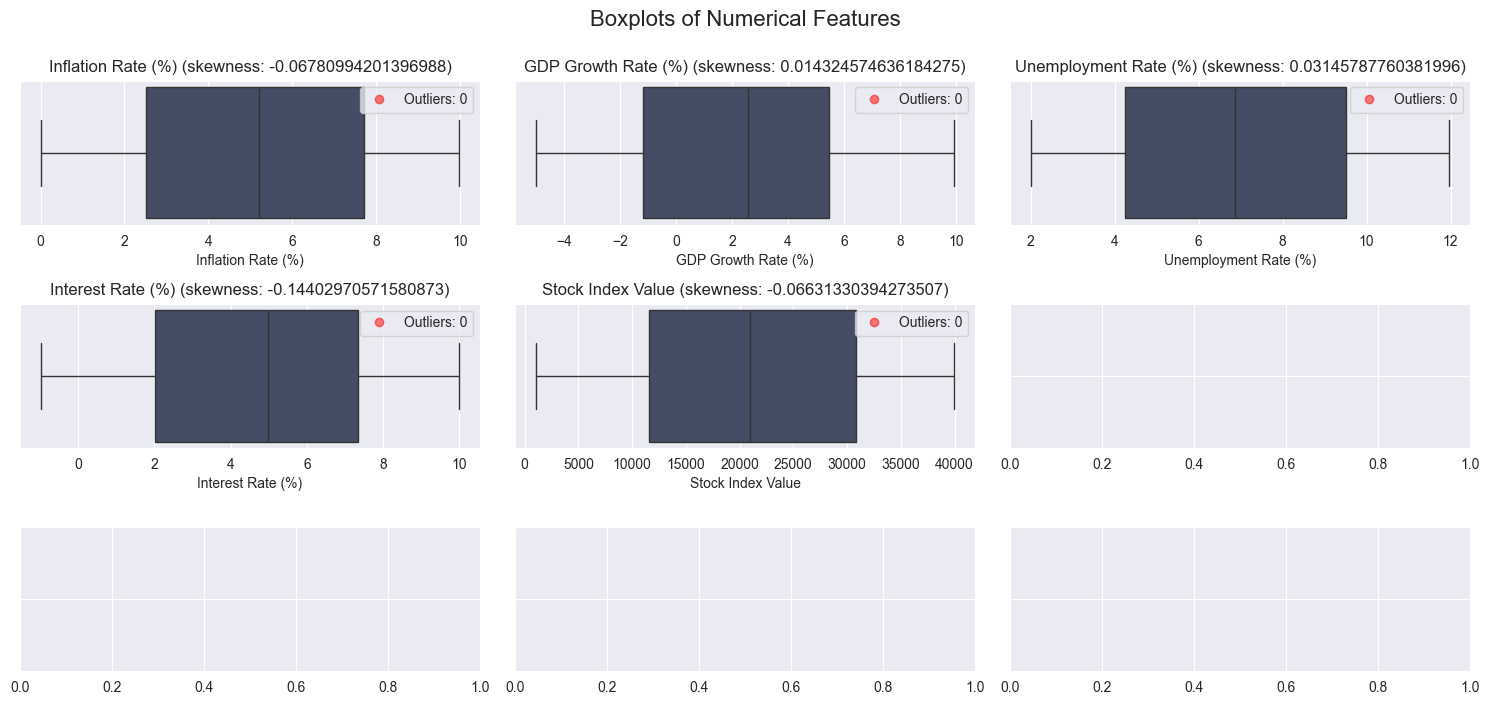

In [73]:
outliers_df = plot_numerical_features_boxplot(data=df, columns_list=numeric_cols, rows=3, cols=3, title='Boxplots of Numerical Features')

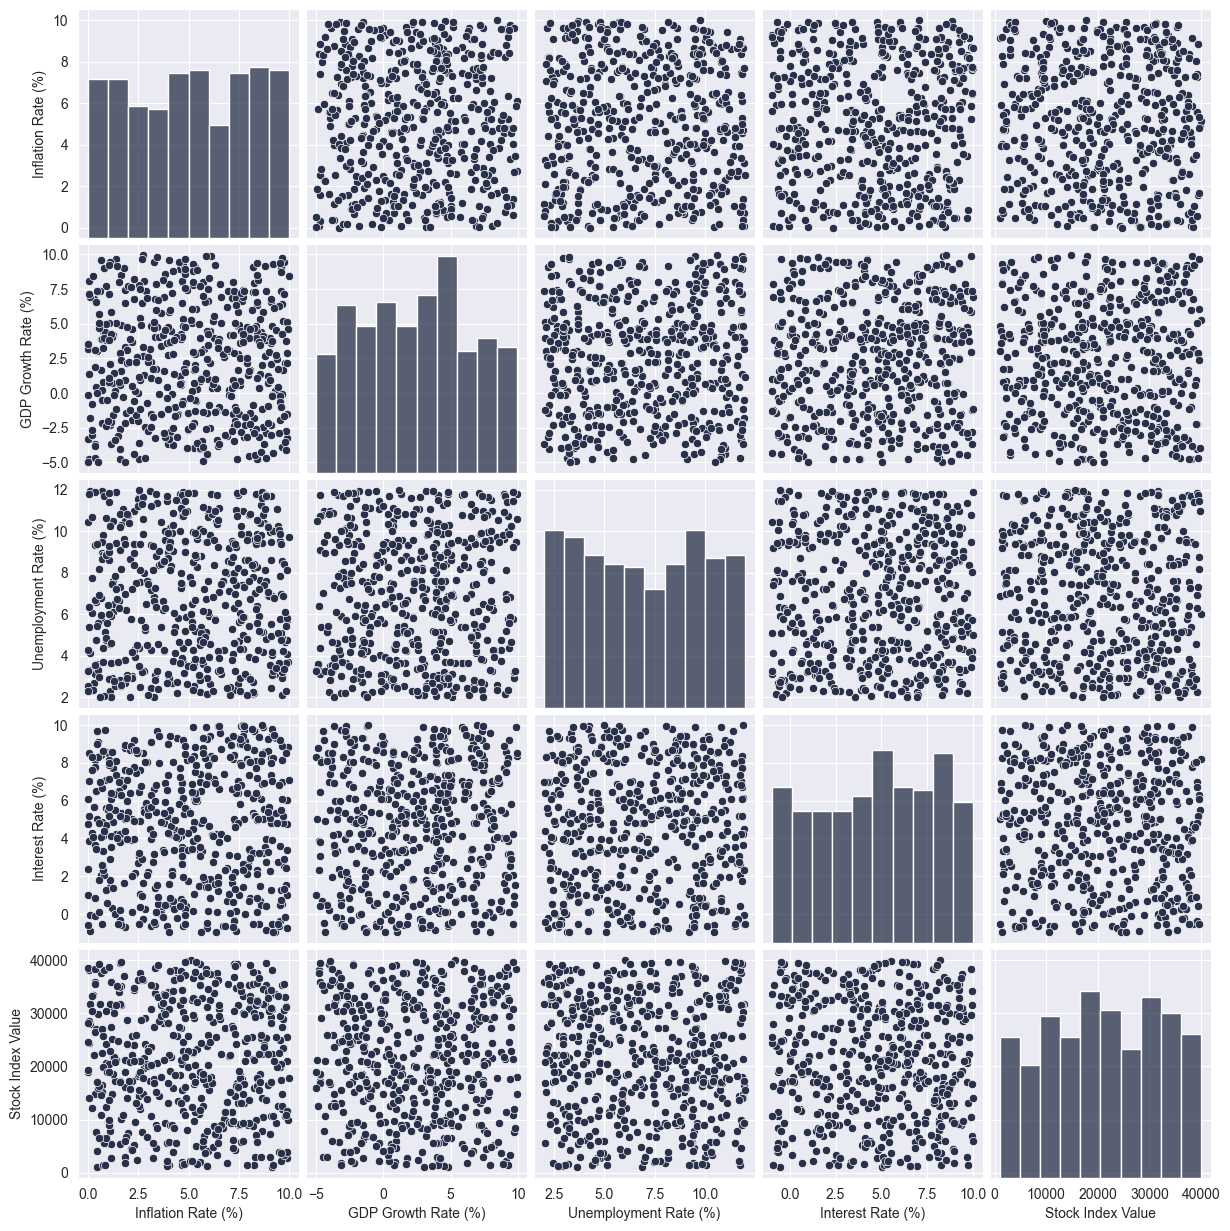

<Figure size 800x600 with 0 Axes>

In [74]:
# Pairplot for Noises
colors = ["#283149", "#404B69", "#DBEDF3"]

sns.set_style("darkgrid")
sns.set_palette(colors)
sns.pairplot(df[numeric_cols])
plt.figure(figsize=(8, 6))
plt.suptitle('Check for Noises', y=1, fontsize=25)
plt.show()